In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

Defining Dataset Path On the Google Drive

In [2]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

epochs = 20
batch_size = 32

#define paths
covid_path = 'drive/My Drive/Covid Detection/chest/Chest_COVID'
noncovid_path = 'drive/My Drive/Covid Detection/chest/Chest_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

Feteching Images From The Dataset Folder

In [3]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
# print(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

Visualization of Images

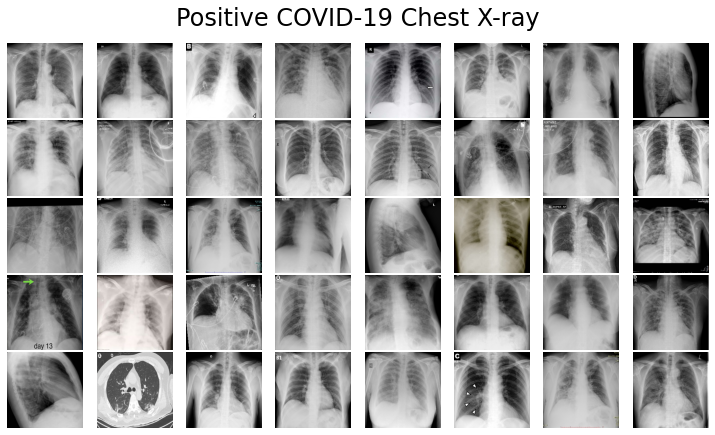

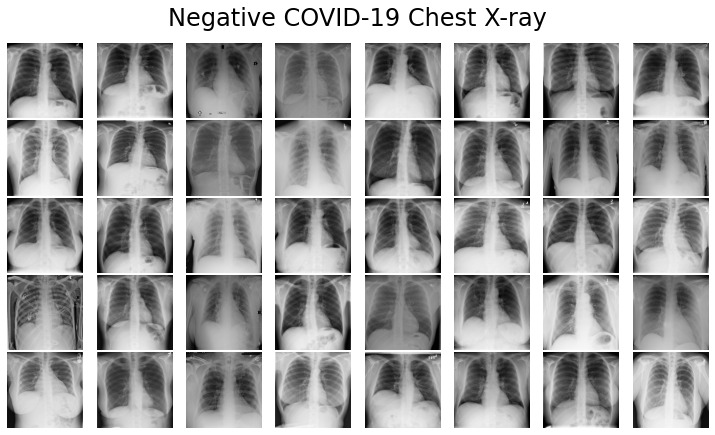

In [4]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

Normalization

In [5]:
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

Splitting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories(0 and 1)
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

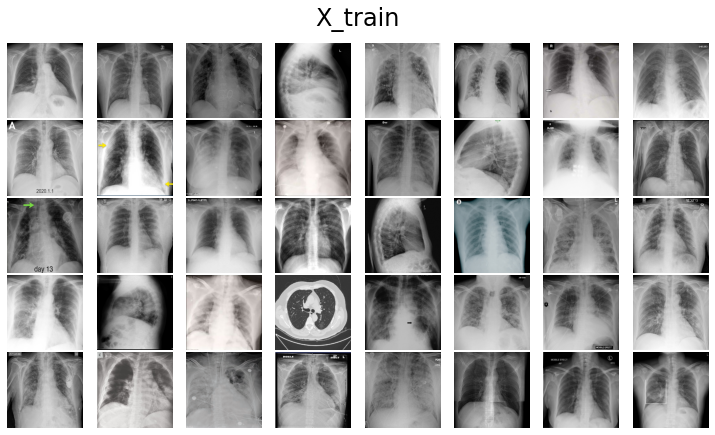

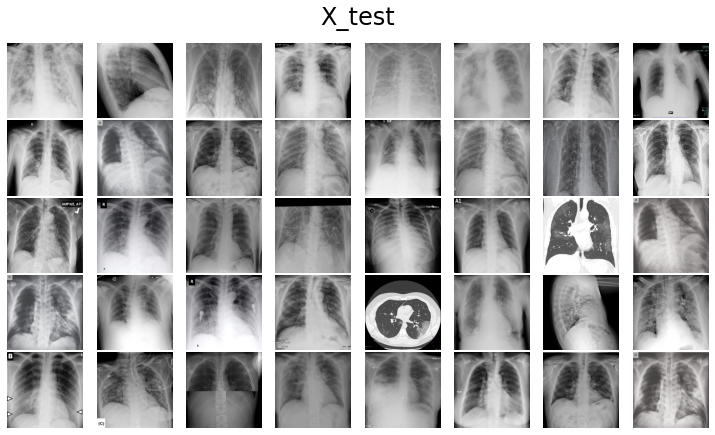

In [7]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

Model

In [8]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80142336/80134624 [==============================] - 2s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [11]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=20)

Epoch 1/20
23/23 [==============================] - 388s 16s/step - loss: 1.3937 - accuracy: 0.5406 - val_loss: 0.6862 - val_accuracy: 0.6895
Epoch 2/20
23/23 [==============================] - 386s 16s/step - loss: 0.6049 - accuracy: 0.7164 - val_loss: 0.5093 - val_accuracy: 0.7526
Epoch 3/20
23/23 [==============================] - 386s 16s/step - loss: 0.5311 - accuracy: 0.7540 - val_loss: 0.4768 - val_accuracy: 0.7895
Epoch 4/20
23/23 [==============================] - 387s 16s/step - loss: 0.4670 - accuracy: 0.7758 - val_loss: 0.4658 - val_accuracy: 0.8105
Epoch 5/20
23/23 [==============================] - 387s 16s/step - loss: 0.4418 - accuracy: 0.7903 - val_loss: 0.5040 - val_accuracy: 0.7632
Epoch 6/20
23/23 [==============================] - 386s 16s/step - loss: 0.4568 - accuracy: 0.7841 - val_loss: 0.4029 - val_accuracy: 0.8211
Epoch 7/20
23/23 [==============================] - 387s 17s/step - loss: 0.4583 - accuracy: 0.7824 - val_loss: 0.3908 - val_accuracy: 0.8263
Epoch 

In [12]:
model.save('vgg_chest.h5')

In [13]:
model.save_weights('vggweights_chest.hdf5')

In [14]:
model = load_model('vgg_chest.h5')

In [15]:
y_pred = model.predict(X_test, batch_size=batch_size)

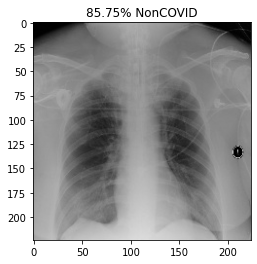

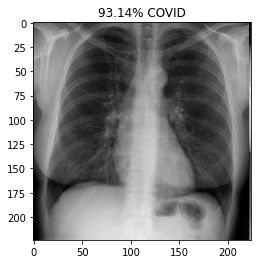

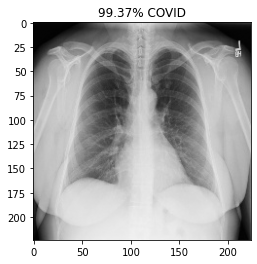

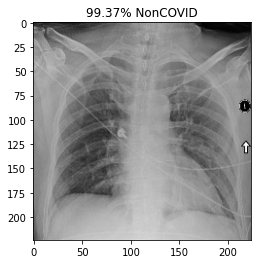

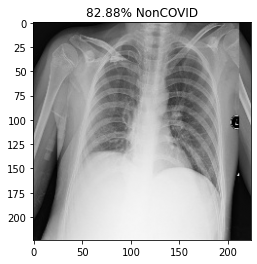

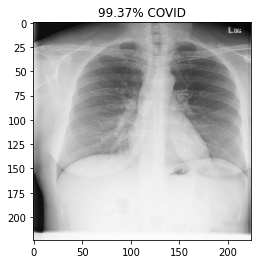

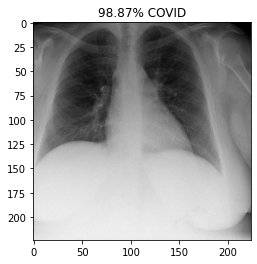

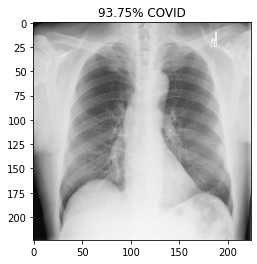

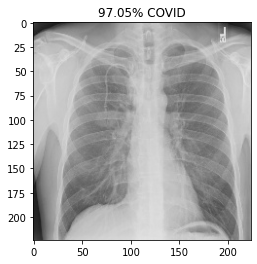

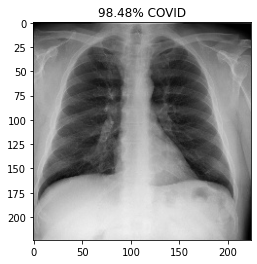

In [16]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [17]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

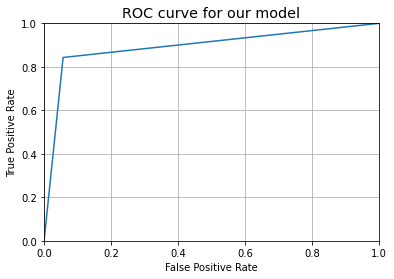

In [18]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


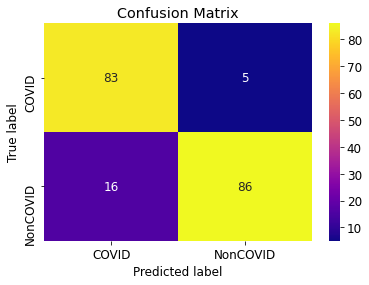

Confusion Matrix with Normalized Values


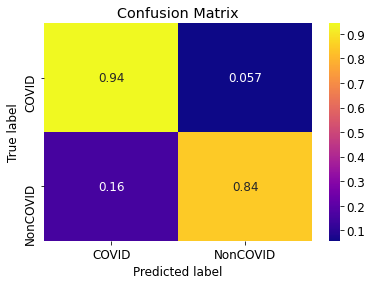

In [19]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        88
           1       0.95      0.84      0.89       102

    accuracy                           0.89       190
   macro avg       0.89      0.89      0.89       190
weighted avg       0.90      0.89      0.89       190



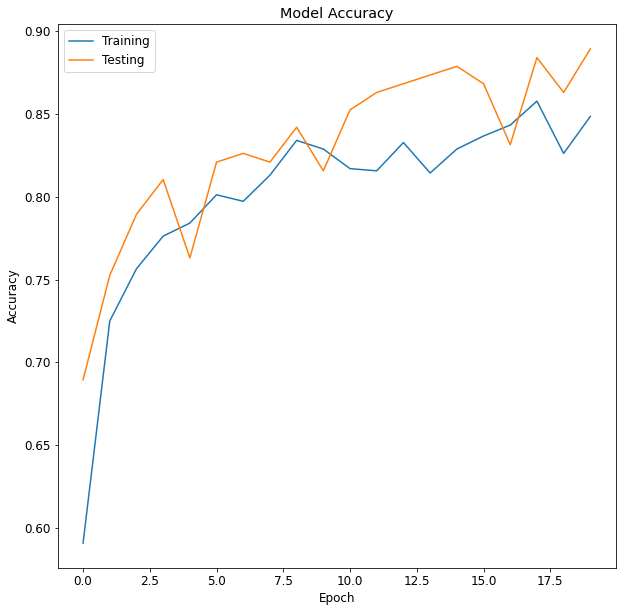

In [21]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

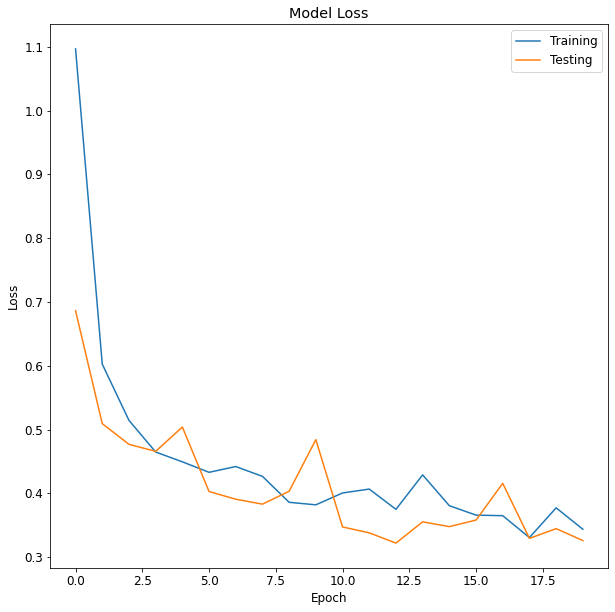

In [22]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()